In [2]:
import kipoi
import sys
sys.path.insert(0,'/srv/scratch/manyu/software/modisco_private/modisco/visualization/')
import viz_sequence
import tensorflow
from keras.layers import Conv1D
import os
import tensorflow as tf
import keras.backend as K
DEFER_DELETE_SIZE=int(250 * 1e6)
def create_tensorflow_session(visiblegpus):
    os.environ['CUDA_VISIBLE_DEVICES'] = str(visiblegpus)
    session_config = tf.ConfigProto()
    session_config.gpu_options.deferred_deletion_bytes = DEFER_DELETE_SIZE
    session_config.gpu_options.per_process_gpu_memory_fraction = 0.45
    session = tf.Session(config=session_config)
    K.set_session(session)
    return session
sess=create_tensorflow_session(0)

In [14]:
import numpy as np

In [5]:
path_to_trained_deepbind_model_arch='/mnt/lab_data/kundaje/manyu/kipoi_models/deepbind_CEBPB_HeLa-S3_val20/model.arch.json'
path_to_trained_deepbind_model_weights='/mnt/lab_data/kundaje/manyu/kipoi_models/deepbind_CEBPB_HeLa-S3_val20/model.weights.h5'

In [6]:
from keras.models import model_from_json

In [7]:
with open(path_to_trained_deepbind_model_arch,'r') as f:
    model_cebpb_deepbind_trained=model_from_json(f.read())

/users/manyu/anaconda3/envs/kipoi_model_loader/lib/python2.7/site-packages/keras/engine/topology.py:1269: UserWarning: Update your `InputLayer` call to the Keras 2 API: `InputLayer(dtype="float32", batch_input_shape=[None, 101..., sparse=False, name="data/genome_data_dir")`
  return cls(**config)
/users/manyu/anaconda3/envs/kipoi_model_loader/lib/python2.7/site-packages/keras/engine/topology.py:1269: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_initializer="he_normal", kernel_constraint=None, activity_regularizer=None, trainable=True, input_shape=(None, Non..., padding="valid", strides=1, filters=16, use_bias=True, name="convolution1d_1", bias_regularizer=None, bias_constraint=None, kernel_regularizer=None, activation="linear", kernel_size=32)`
  return cls(**config)
/users/manyu/anaconda3/envs/kipoi_model_loader/lib/python2.7/site-packages/keras/engine/topology.py:1269: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(

In [8]:
model_cebpb_deepbind_trained.load_weights(path_to_trained_deepbind_model_weights)

In [9]:
model_cebpb_trained_conv_layer=model_cebpb_deepbind_trained.get_layer('convolution1d_1').get_weights()

In [10]:
filters,biases=model_cebpb_trained_conv_layer[0],model_cebpb_trained_conv_layer[1]

In [21]:
filters.shape,biases.shape

((32, 4, 16), (16,))

In [22]:
filters=np.expand_dims(filters,axis=-1).transpose((1,0,3,2))
print(filters.shape)

(4, 32, 1, 16)


In [15]:
from  pybedtools.bedtool import BedTool
from genomelake.extractors import ArrayExtractor

In [23]:
intervals_bedtool=BedTool('./intervals_to_evaluate/CEBPB_HeLAS3_chr8.bed')

In [24]:
hg19_extractor=ArrayExtractor('/srv/scratch/genomelake_data/hg19.genome.fa/')

In [25]:
intervals=[intervals_bedtool[i] for i in range(300)]

In [26]:
intervals_array=hg19_extractor(intervals)

In [27]:
intervals_array.shape

(300, 101, 4)

In [28]:
intervals_array=np.expand_dims(intervals_array,axis=-1).transpose((0,2,1,3))
print(intervals_array.shape)

(300, 4, 101, 1)


In [29]:
import sys
sys.path.insert(0,'/srv/scratch/manyu/software/modisco_private/modisco/visualization/')

In [30]:
import viz_sequence

In [46]:
%load_ext autoreload
%autoreload 2
from pwm_utils import *

In [47]:
pfm_cebpb_list = get_counts_list(intervals=intervals_array,filters=filters,biases=biases)

All shapes are compatible:
Proceeding with convolutions:
Doing filter 0
Doing filter 1
Doing filter 2
Doing filter 3
Doing filter 4
Doing filter 5
Doing filter 6
Doing filter 7
Doing filter 8
Doing filter 9
Doing filter 10
Doing filter 11
Doing filter 12
Doing filter 13
Doing filter 14
Doing filter 15


[300, 300, 300, 300, 126, 300, 300, 300, 300, 300, 300, 99, 300, 300, 300, 299]

Filter Number 0


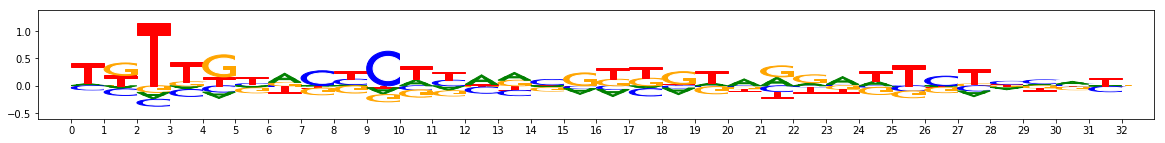

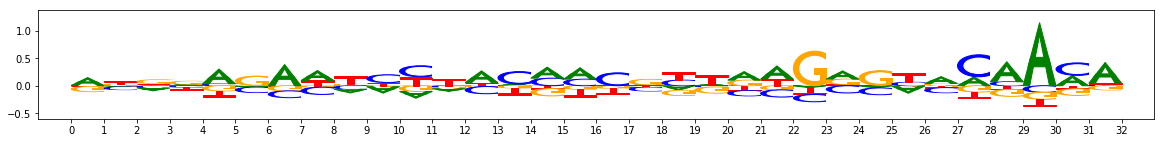

Filter Number 1


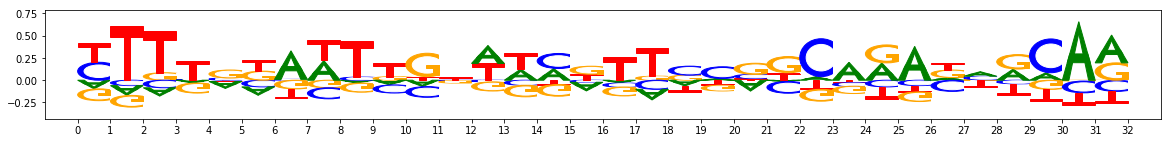

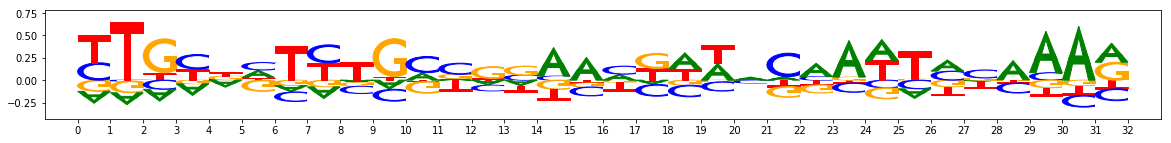

Filter Number 2


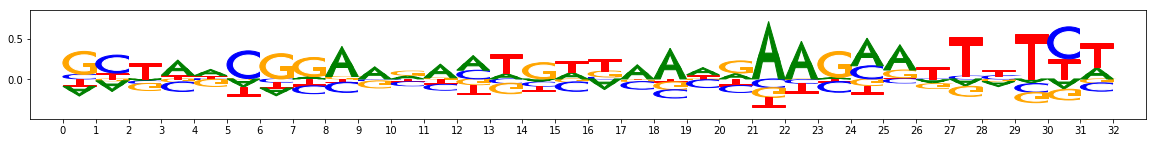

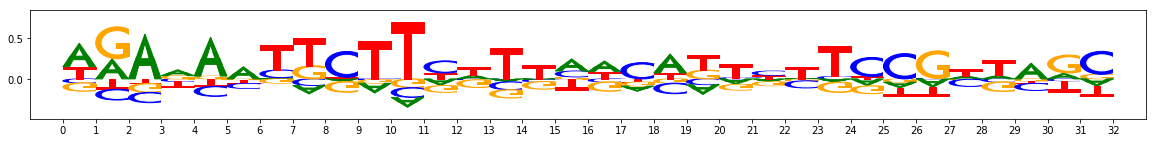

Filter Number 3


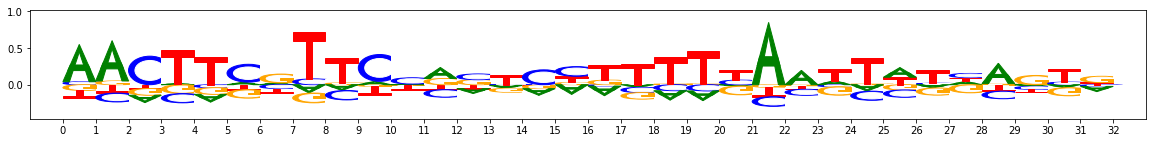

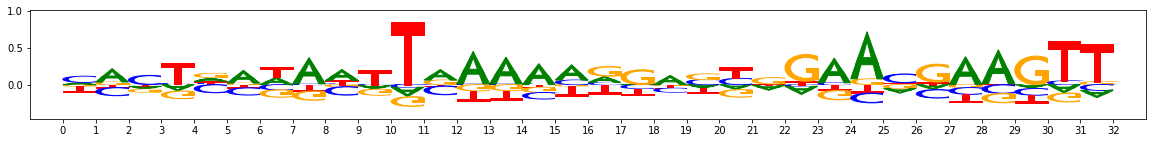

Filter Number 4


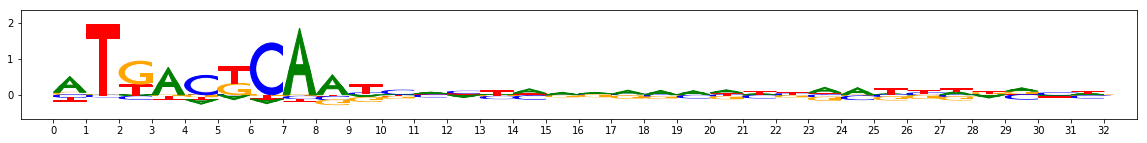

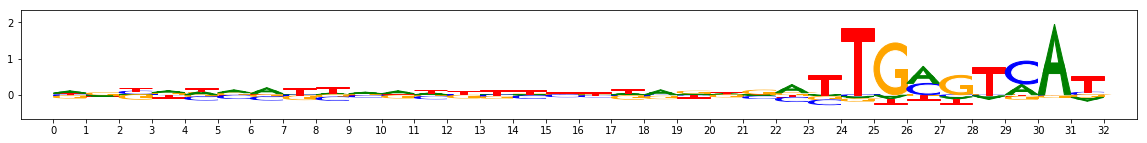

Filter Number 5


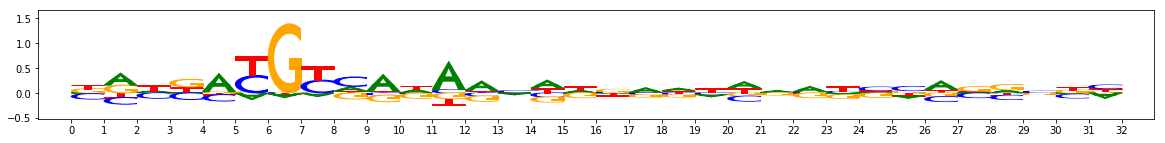

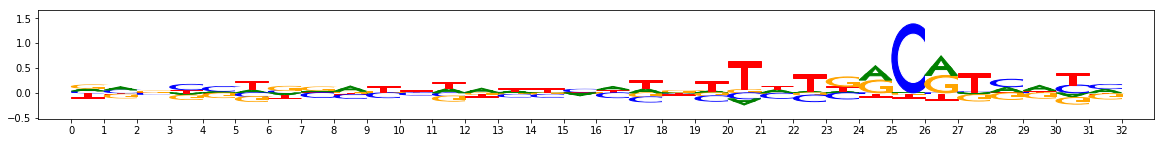

Filter Number 6


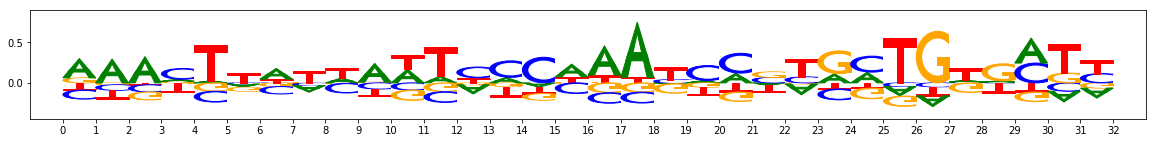

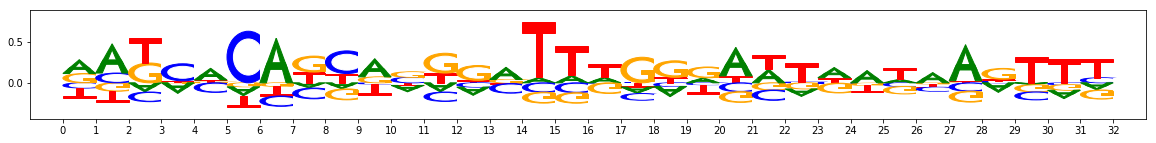

Filter Number 7


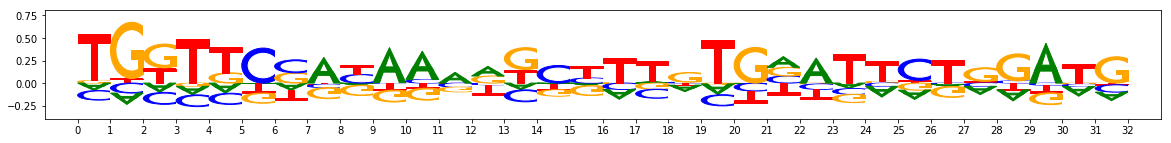

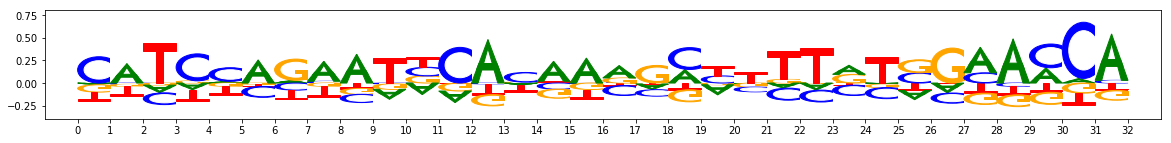

Filter Number 8


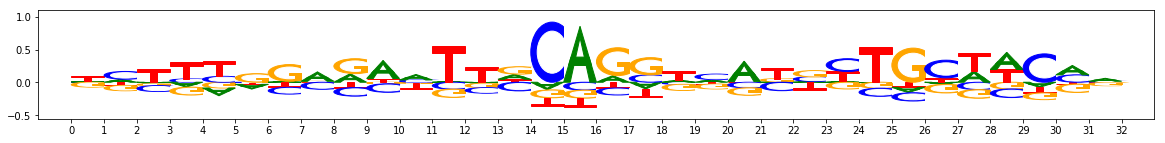

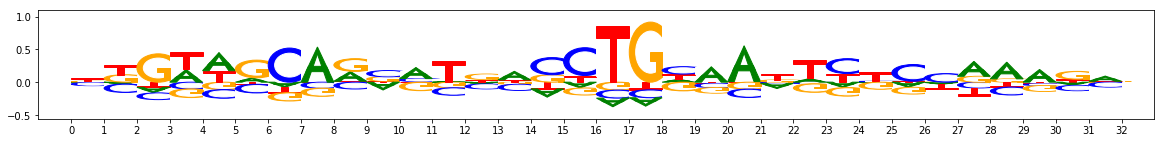

Filter Number 9


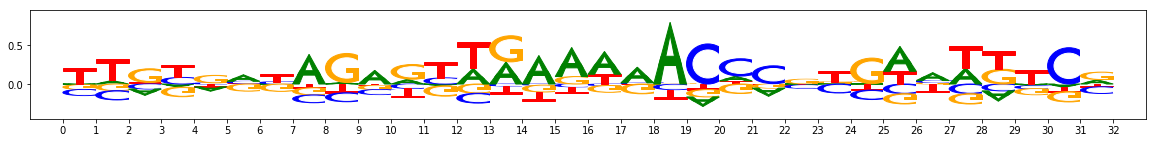

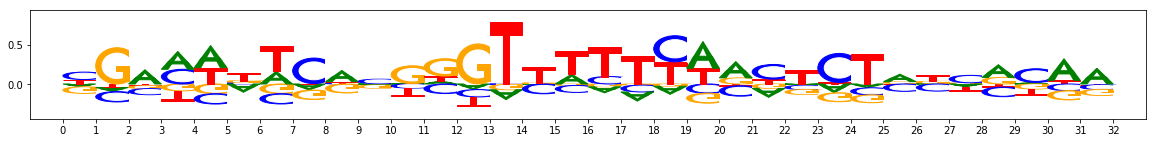

Filter Number 10


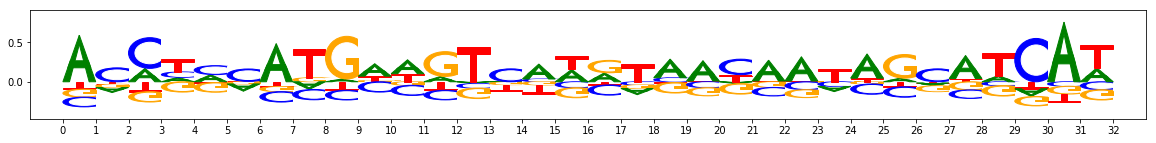

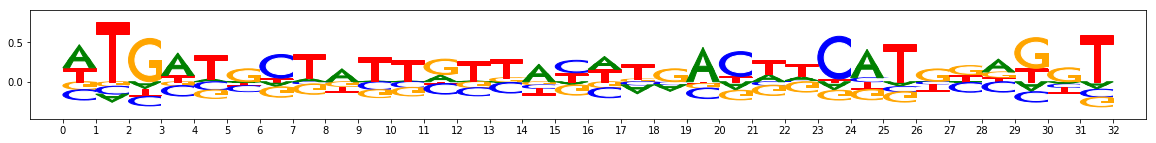

Filter Number 11


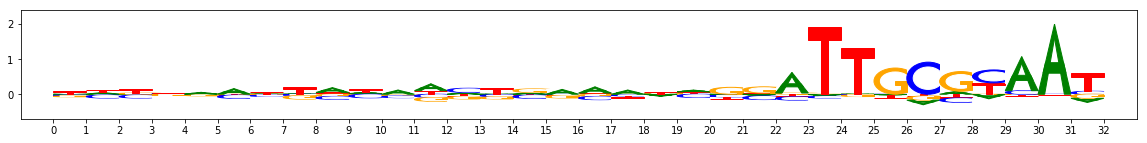

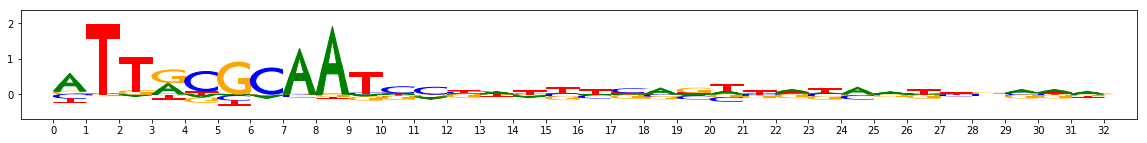

Filter Number 12


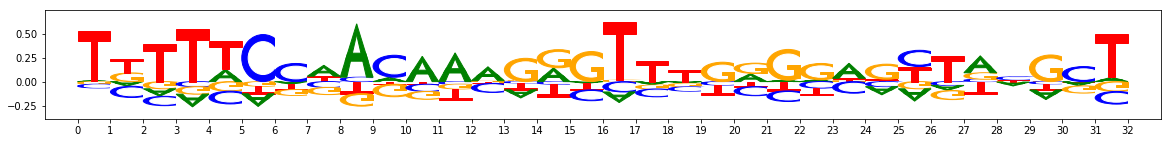

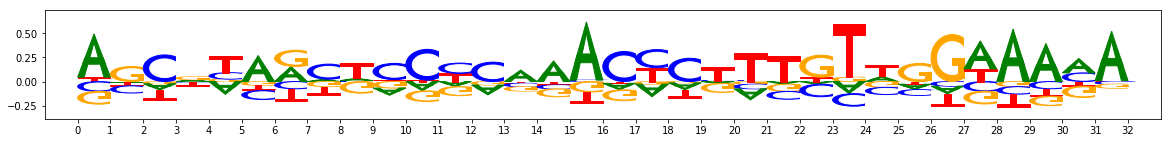

Filter Number 13


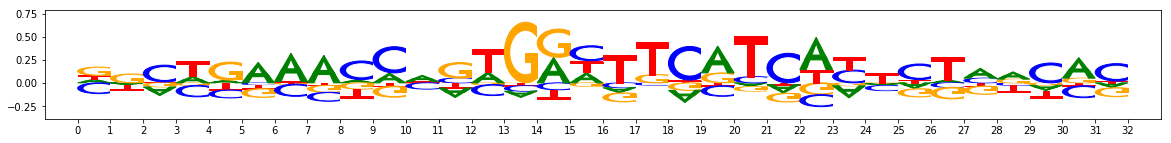

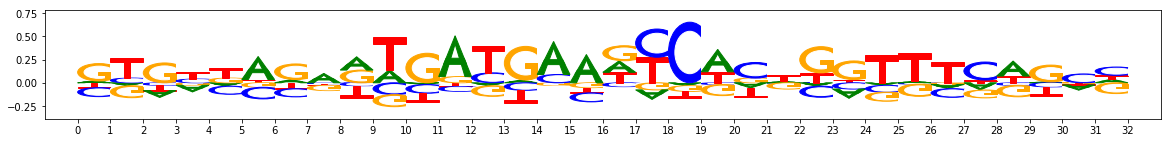

Filter Number 14


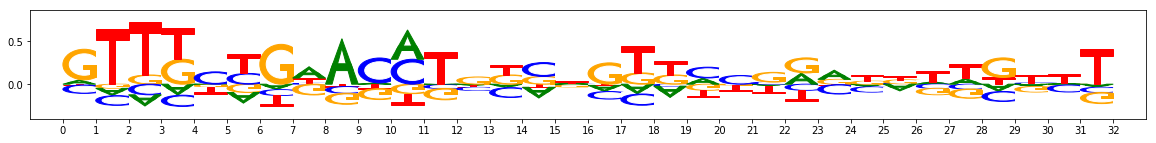

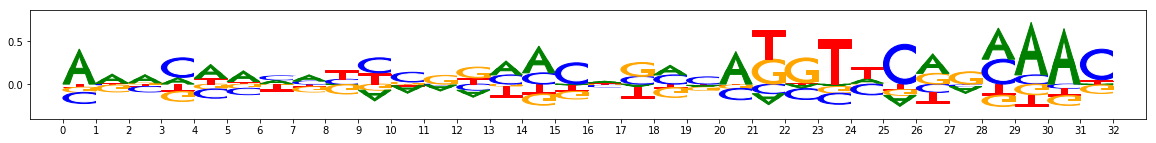

Filter Number 15


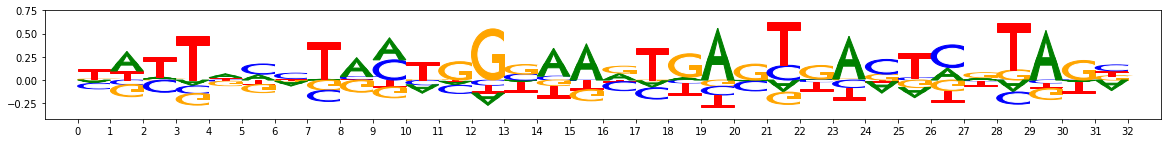

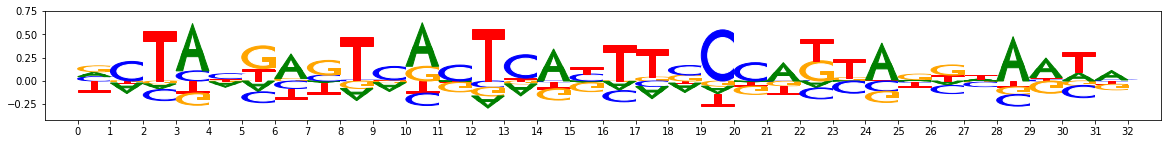

In [43]:
for num_,elem in enumerate(pfm_cebpb_list):
    pfm,counts = elem[0],elem[1]
    if counts>0:
        pfm/=(counts+0.0)
        print("Filter Number %s"%(str(num_)))
        viz_sequence.plot_weights(get_information_content_matrix(pfm_with_pseudocount(pfm)))
        viz_sequence.plot_weights(get_information_content_matrix(pfm_with_pseudocount(pfm[::-1,::-1])))

In [51]:
import pwm_utils

In [52]:
info_list=pwm_utils.information_matrix_pwms(pfm_cebpb_list)

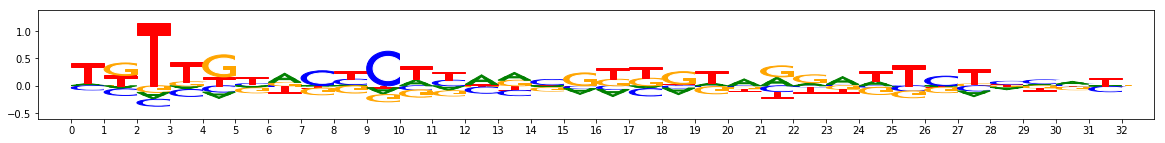

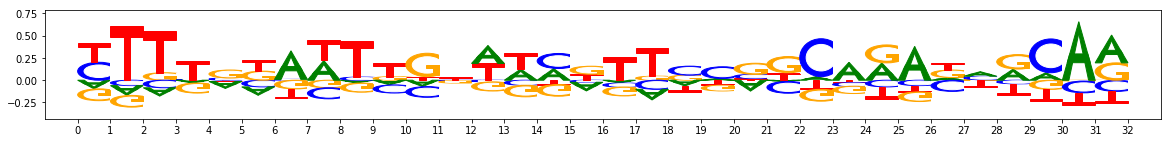

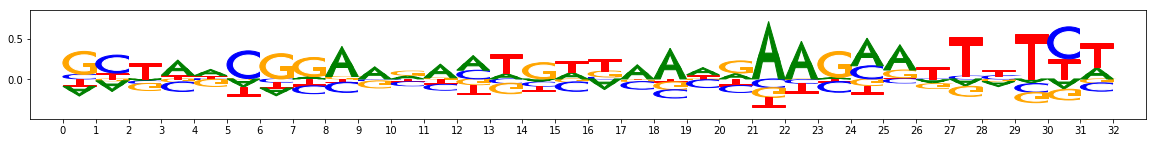

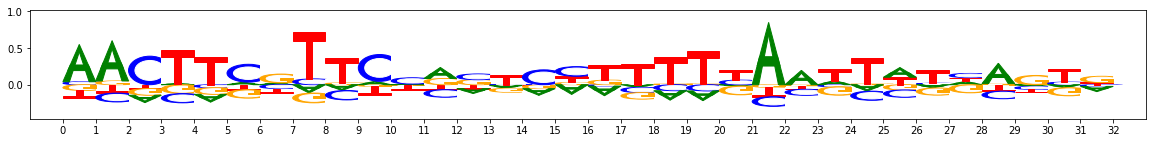

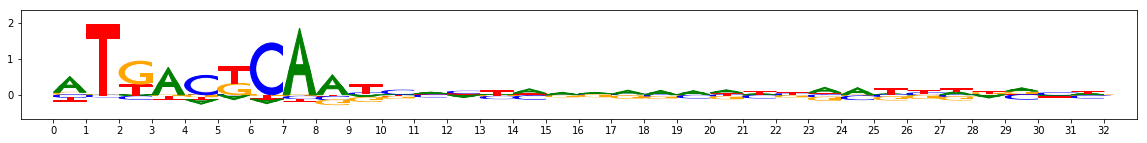

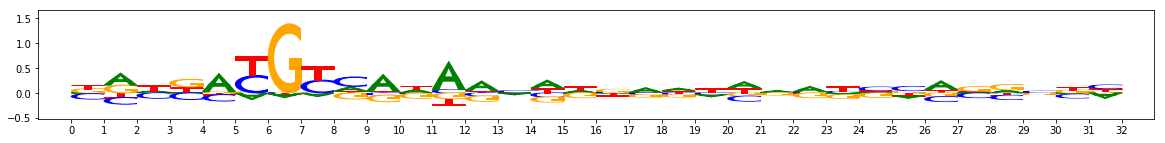

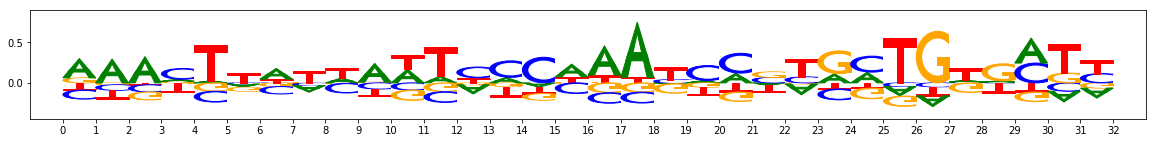

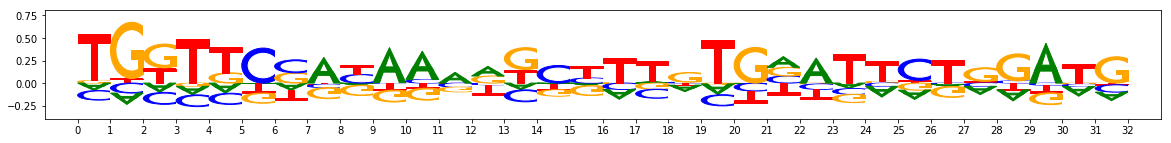

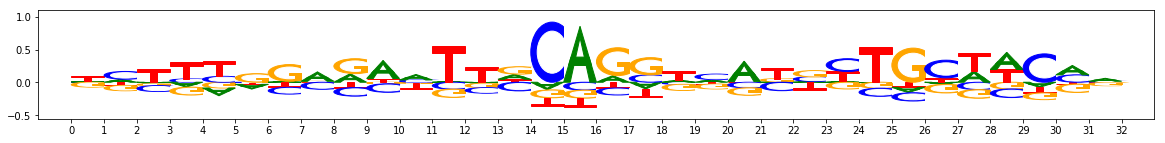

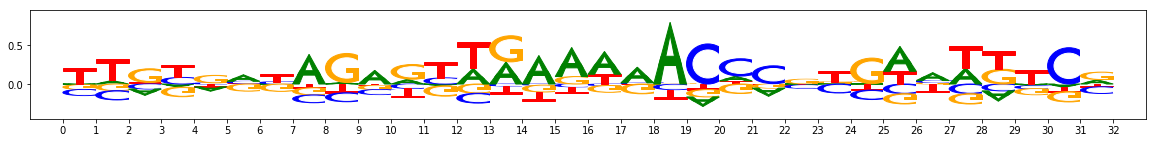

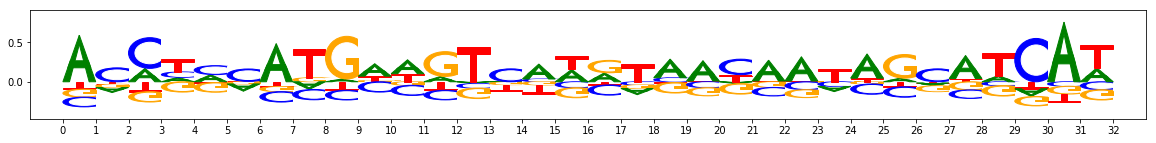

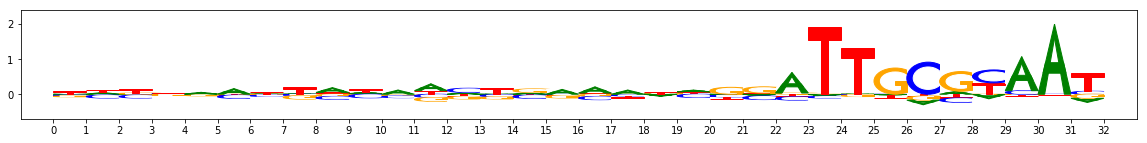

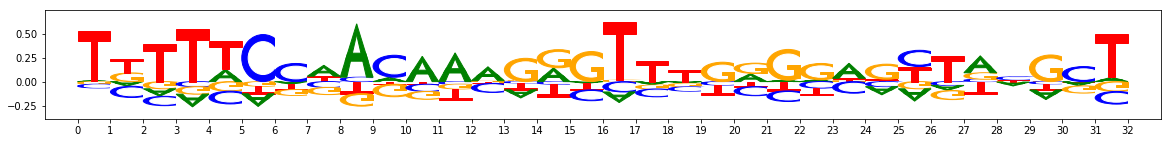

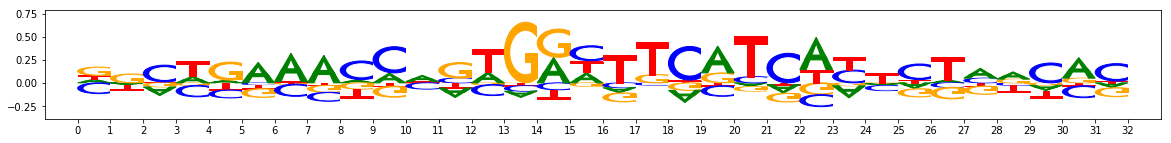

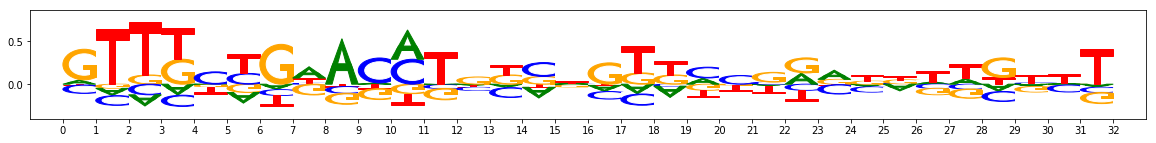

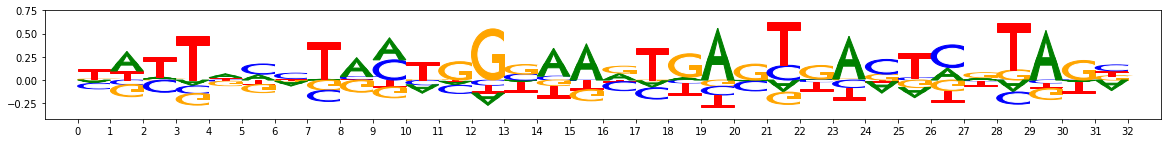

In [54]:
for pwm in info_list:
    viz_sequence.plot_weights(pwm)